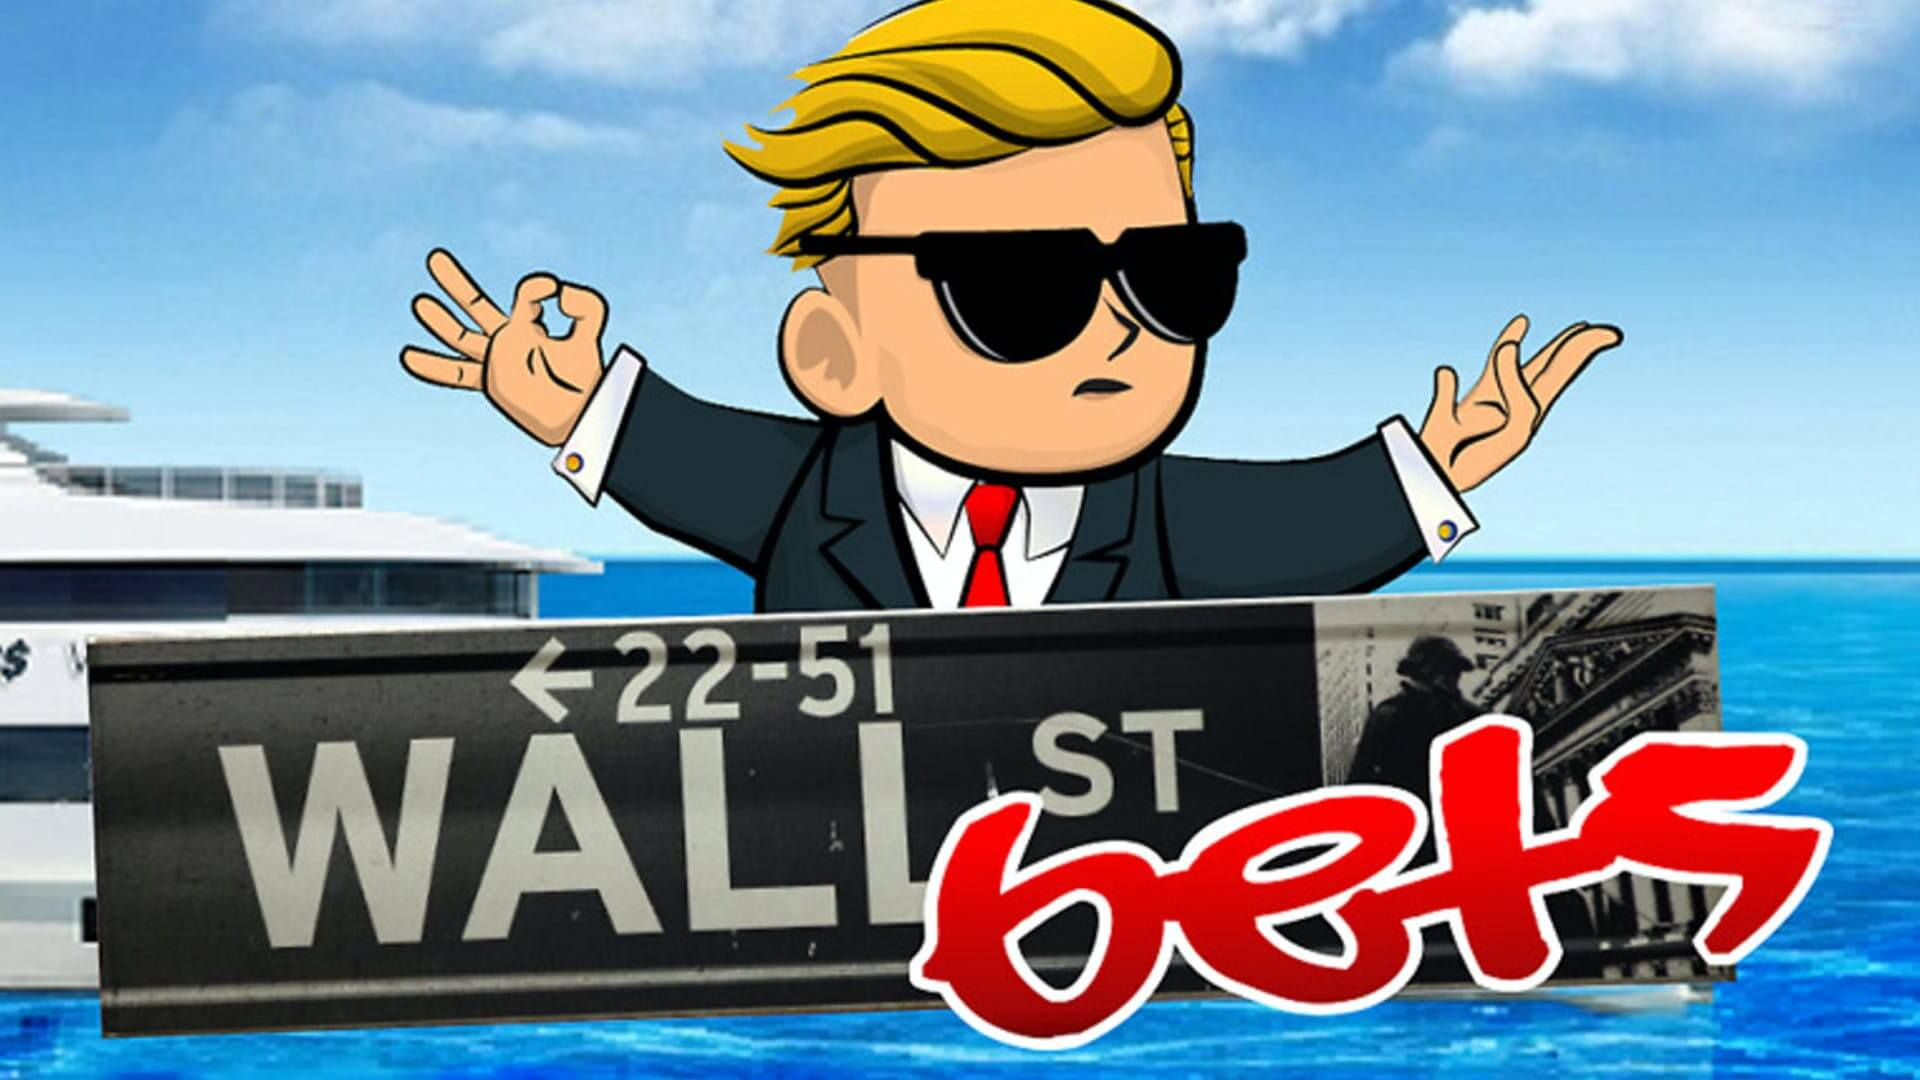

# Reddit Sentiment Analysis

By Doug Mill
<br>
github.com/cyborgsage

## Overview

Interest in the stock market has grown in the past few years, with COVID seemingly fueling some of the risk on behavior within markets. Last year, this increased interest crossed over into many other facets of our lives. With the convergence of reddit, social media, memes, the stock market, and mainstream media, the famed GameStop and AMC short squeezes captivated financial audiences in late January of this year. Through data science and research, we can take these newfound information sources and use them to benefit the broader retail trading audience.

## Business Understanding

I am representing an independent asset management and research firm that was contacted by an international pension and sovereign wealth fund. Previously, they had only been subscribed to traditional market news. When the GME and AMC squeezes broke the news, the fund took notice. They have asked me to publish research about whether the wallstreetbets subreddit is worth mining as an information source and inquired about diversifying into meme stocks. My goal here is to fulfill their needs efficiently and practically. I took a two-pronged approach to NLP; training classification models with VADER sentiment as my target, and using NLP to find the top mentioned tickers on r/wsb. My firm has decided to make a financial product based on the most frequently mentioned stocks. This product is known as RSAH and is an equally weighted ETF based on wallstreetbets mention data and will be rebalanced monthly.

## Data Understanding

The data that was used for this project was exclusively scraped from the wallstreetbets subreddit of the social media platform Reddit. A subreddit is a subgroup of the platform dedicated to their own shared interest. In the case of wallstreetbets, that happens to be trading. When I first joined the group in 2019, directional single leg options were almost exclusively promoted. Shares were frowned upon. With the humungous movements in stocks such as GME and AMC, things changed in the subreddit forever. The popularity of the board skyrocketed, reaching mainstream appeal, and people were seeing huge gains in shares. What made these companies unique was that AMC was a company on the verge of bankruptcy. Gamestop was an outdated brick and mortar video game retailer. How did these companies explode? The answer lies partially in shorts, gamma squeezing, and the wallstreetbets subreddit. In order to investigate, I scraped 100k comments containing the keyword "AMC" and 100k comments containing the keyword "GME" from wallstreetbets. The comments were posted between 1/1/21 and 11/20/21, when the project commenced. I used the PushShift API which does a great job with collected big amounts of data relative to the Reddit API.

## Data Preparation

For data preparation, I took my files straight from the API and then cleaned them out. I kept 6 relevant columns out of 40. These columns included "body" (actual comment), "score" (peer feedback), "total awards received" (peer feedback), "created utc" (date-time), "author", and "permalink" (kept these to verify legitimacy of comments). After cleaning out the irrelevant data, I cleaned the comments themselves. I then applied the default VADER for my time series data. This gave me positive, neutral, negative, and compound scores for each comment. I shipped these dataframes off to csvs. For the classification datasets known as "amc_modeling_2" and "gme_modeling", I tuned VADER by updating the lexicon with some new words and values. My full EDA can be found for both AMC and GME in the appendix folder.

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
import matplotlib.pyplot as plt
import math
from datetime import datetime
import datetime as dt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
from xgboost import XGBClassifier
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-04b6c45f9554>:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
amc_raw = pd.read_csv('data/amc_comments.csv', low_memory=False)

In [3]:
relevant_columns=['body','score','total_awards_received','created_utc','author','permalink']
amc_raw = amc_raw[relevant_columns]

In [4]:
gme_raw = pd.read_csv('data/gme_comments.csv', low_memory=False)
gme_raw = gme_raw[relevant_columns]

In [5]:
stopwords_list = stopwords.words('english')

In [6]:
def new_cleaner(comment):
    punctuation = set(string.punctuation)
    x = comment
    x = re.sub(r'@[\w]*', '', x) #remove @ mentions
    x = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', x) #remove URLs and links
    x = ''.join(ch for ch in x if ch not in punctuation) #remove punctuation
    x = x.replace("[^a-zA-z]", " ") #remove special chars
    x = [word.lower() for word in x.split() if word.lower() not in stopwords_list] #lowercase
    return ' '.join(x)

In [7]:
new_words = {
    'citron': -4.0,'hindenburg': -4.0,'moon': 4.0,'highs': 2.0,'mooning': 4.0,'long': 2.0,'short': -2.0,'call': 4.0,
    'calls': 4.0,'put': -4.0,'puts': -4.0,'breakout': 2.0,'tendie': 2.0,'tendies': 2.0,'town': 2.0,'overvalued': -3.0,
    'undervalued': 3.0,'buy': 4.0,'sell': -4.0,'gone': -1.0,'gtfo': -1.7,'paper': -1.7,'bullish': 4.0,'bearish': -4.0,
    'bagholder': -1.7,'stonk': 1.9,'green': 4.0,'money': 1.2,'print': 2.2,'rocket': 4.0,'bull': 4.0,'bear': -4.0,
    'pumping': 2.5,'sus': -3.0,'offering': -2.3,'rip': -4.0,'downgrade': -3.0,'upgrade': 3.0,'maintain': 1.0,'pump': 1.9,
    'hot': 1.5,'drop': -2.5,'rebound': 1.5,'crack': 2.5,'gang': 2.0,'scam': -2.0,'chamath': -2.0,'snake': -2.0,
    'squeeze': 3.0,'bag': -4.0,'fly': 2.0,'way': 2.0,'high': 2.0,'volume': 2.5,'low': -2.0,'trending': 3.0,'upwards': 3.0,
    'prediction': 1.0,'cult': -1.0,'big': 2.0}

In [8]:
new_vader = SentimentIntensityAnalyzer()
new_vader.lexicon.update(new_words)

In [9]:
def find_sentiment(post):
    if new_vader.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif new_vader.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

In [10]:
amc_raw['cleaned_body'] = amc_raw['body'].map(lambda x: new_cleaner(x))
amc_raw['new_sentiment'] = amc_raw['cleaned_body'].apply(lambda x: find_sentiment(x))

In [11]:
gme_raw['cleaned_body'] = gme_raw['body'].map(lambda x: new_cleaner(x))
gme_raw['body_sentiment'] = gme_raw['cleaned_body'].apply(lambda x: find_sentiment(x))

In [12]:
# amc_raw.to_csv('data/amc_modeling.csv', index=False)
# gme_raw.to_csv('data/gme_modeling.csv', index=False)

The data preprocessing included converting comments to lowercase, removing "@" mentions between users, removing links, removing stopwords, and vectorizing.

## Modeling

Modeling AMC and GME comments with classification such as naive bayes, decision tree, random forest, and xgboost. Also implemented pipelines and cross validation for each model.

In [13]:
amc = pd.read_csv('data/amc_modeling.csv', low_memory=False)
amc.dropna(inplace=True)

In [14]:
gme = pd.read_csv('data/gme_modeling.csv', low_memory=False)
gme.dropna(inplace=True)

In [15]:
def eval_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    print(f'Training Accuracy: {model.score(X_train, y_train)}')
    y_pred = model.predict(X_test)
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
    plot_confusion_matrix(model, X_test, y_test)

## AMC sentiment prediction

In [16]:
# VADER predictions have been established as target.
X = amc['cleaned_body']
y = amc['new_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Naive Bayes

In [17]:
nb_pipe = Pipeline(steps=[('pre', CountVectorizer(stop_words=stopwords_list, max_features=200)),
                         ('nb', MultinomialNB())])
nb_cv = cross_validate(estimator=nb_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
nb_cv

{'fit_time': array([3.07623601, 3.07732224, 3.01923418, 2.9682374 , 2.90423775]),
 'score_time': array([0.33302379, 0.33291101, 0.33200049, 0.35301256, 0.33200049]),
 'test_score': array([0.71722434, 0.71188139, 0.7128164 , 0.71455286, 0.71922794])}

Training Accuracy: 0.7168636879716823
Test Accuracy: 0.7166212534059946


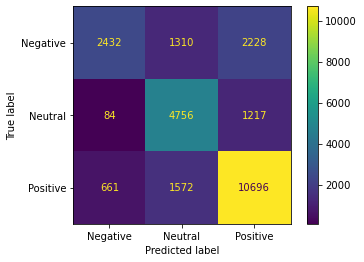

In [18]:
nb_pipe.fit(X_train, y_train)
eval_model(nb_pipe, X_train, X_test, y_train, y_test)

### Random Forest

In [19]:
rf_pipe = Pipeline(steps=[('pre', CountVectorizer(stop_words=stopwords_list, max_features=200)),
                         ('rf', RandomForestClassifier())])
rf_cv = cross_validate(estimator=rf_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
rf_cv

{'fit_time': array([119.92464805, 120.46465492, 120.53264976, 120.89285684,
        119.46623635]),
 'score_time': array([1.05902815, 0.94399381, 0.87602258, 1.04599881, 1.18299651]),
 'test_score': array([0.7331864 , 0.72844453, 0.73652575, 0.72944634, 0.73211781])}

Training Accuracy: 0.9108261537434048
Test Accuracy: 0.7308863599935888


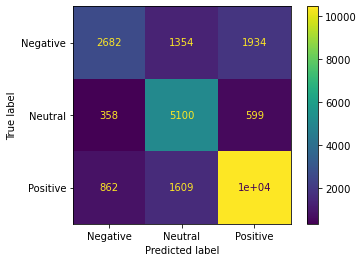

In [20]:
rf_pipe.fit(X_train, y_train)
eval_model(rf_pipe, X_train, X_test, y_train, y_test)

### Decision Tree

In [21]:
dt_pipe = Pipeline(steps=[('pre', CountVectorizer(stop_words=stopwords_list, max_features=200)),
                         ('dt', DecisionTreeClassifier())])
dt_cv = cross_validate(estimator=dt_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
dt_cv

{'fit_time': array([10.46394014, 10.51093793, 10.67993569, 10.64403272, 10.38493872]),
 'score_time': array([0.33300304, 0.32607436, 0.24957681, 0.25148582, 0.29637599]),
 'test_score': array([0.68042476, 0.67842116, 0.69217926, 0.68576772, 0.6842984 ])}

Training Accuracy: 0.9108662258732385
Test Accuracy: 0.6880910402308063


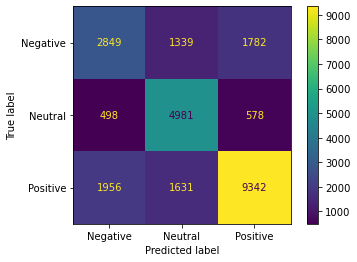

In [22]:
dt_pipe.fit(X_train, y_train)
eval_model(dt_pipe, X_train, X_test, y_train, y_test)

### XGBoost

In [23]:
xgb_pipe = Pipeline(steps=[('pre', CountVectorizer(stop_words=stopwords_list, max_features=200)),
                          ('xgb', XGBClassifier(eval_metric='mlogloss'))])
xgb_cv = cross_validate(estimator=xgb_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
xgb_cv

{'fit_time': array([11.19714546, 11.15004992, 10.79899001,  9.95441771, 11.01488614]),
 'score_time': array([0.33278251, 0.33074689, 0.43015456, 0.50999928, 0.45071387]),
 'test_score': array([0.75095171, 0.7438723 , 0.74821345, 0.74454017, 0.75262139])}

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training Accuracy: 0.7755025712949977
Test Accuracy: 0.7465539349254688


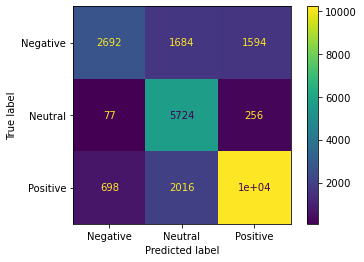

In [24]:
xgb_pipe.fit(X_train, y_train)
eval_model(xgb_pipe, X_train, X_test, y_train, y_test)

## GME sentiment prediction


In [25]:
X = gme['cleaned_body']
y = gme['body_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Naive Bayes

In [26]:
nb_pipe.fit(X_train, y_train)
nb_cv = cross_validate(estimator=nb_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
nb_cv

{'fit_time': array([1.73368168, 1.72425008, 1.75647283, 1.71115756, 1.73527074]),
 'score_time': array([0.31101799, 0.30601692, 0.32479167, 0.3191123 , 0.28253055]),
 'test_score': array([0.69095762, 0.69002336, 0.69009009, 0.69033636, 0.69133743])}

Training Accuracy: 0.6932851060422033
Test Accuracy: 0.6888488488488489


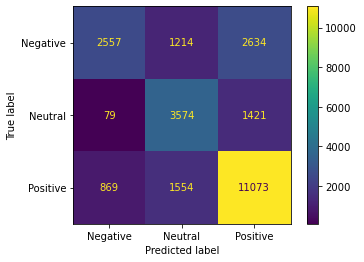

In [27]:
eval_model(nb_pipe, X_train, X_test, y_train, y_test)

### Random Forest

In [28]:
rf_pipe.fit(X_train, y_train)
rf_cv = cross_validate(estimator=rf_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
rf_cv

{'fit_time': array([121.3969233 , 120.93291593, 120.67692709, 119.93792892,
        121.09992528]),
 'score_time': array([0.95820999, 1.04301119, 1.03799844, 1.06399632, 0.96699739]),
 'test_score': array([0.70263597, 0.70804137, 0.70417084, 0.70601975, 0.7126268 ])}

Training Accuracy: 0.9101210576191556
Test Accuracy: 0.7055855855855856


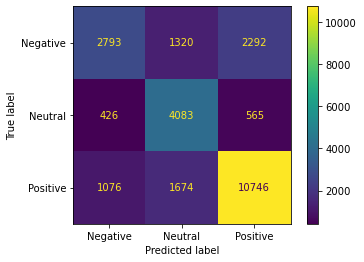

In [29]:
eval_model(rf_pipe, X_train, X_test, y_train, y_test)

### Decision Tree

In [30]:
dt_pipe.fit(X_train, y_train)
dt_cv = cross_validate(estimator=dt_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
dt_cv

{'fit_time': array([11.36621284, 11.15720654, 11.27620959, 11.24920774, 11.12120438]),
 'score_time': array([0.33999753, 0.36499763, 0.33099937, 0.30699801, 0.34099579]),
 'test_score': array([0.65385385, 0.64858192, 0.65392059, 0.65416444, 0.66163908])}

Training Accuracy: 0.9101477516917369
Test Accuracy: 0.6542142142142142


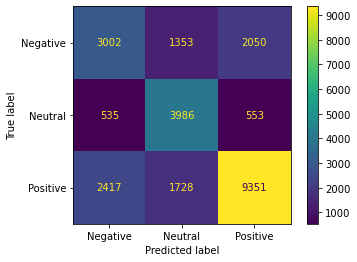

In [31]:
eval_model(dt_pipe, X_train, X_test, y_train, y_test)

### XGBClassifier

In [32]:
xgb_pipe.fit(X_train, y_train)
xgb_cv = cross_validate(estimator=xgb_pipe, X=X_train, y=y_train,
                      scoring='accuracy', cv=5, n_jobs=-1)
xgb_cv

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'fit_time': array([12.74418926, 12.67816782, 12.55716467, 12.24481964, 12.44471788]),
 'score_time': array([0.39497781, 0.33700013, 0.37099767, 0.58295393, 0.51106524]),
 'test_score': array([0.72112112, 0.72592593, 0.72392392, 0.72704218, 0.72644154])}

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training Accuracy: 0.7565634050958985
Test Accuracy: 0.7228028028028028


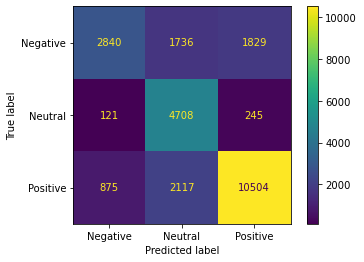

In [33]:
eval_model(xgb_pipe, X_train, X_test, y_train, y_test)

## Evaluation

Given that the XGBoost model had the highest accuracy scores on both AMC and GME, it can be concluded that it was the best model. It was able to score 75% on AMC comments and 72% on GME comments. It fared better than Naive Bayes in both models which was second due to overfitting on the random forest and decision tree. An advantage of these models over VADER is more interpretability.

## Conclusion 

The model did well classifying the sentiment of comments based on the assigned target which was the sentiment registered in EDA through VADER. The alternative to using VADER labeling as my target would be manual labeling of comments in a couple of 100k entry datasets. Therefore the best "truth" in my opinion was using VADER. I did try to tune the lexicon. Given the evolving lingo as well as the sarcasm and context involved with each comment, there is no fool proof method including manual labeling. While I was reading the comments, I found myself between sentiments at times, often even considering all 3. The involvement of VADER in the bigger picture proves to be useful and reliable. <br>
Through iterative modeling, I was able to test out Naive Bayes, decision tree, random forest, and XGBoost. Decision tree and random forest had issues with overfitting which ruled them out for me. Naive Bayes served well as a baseline model but was slightly usurped by XGBoost at 75% accuracy score on AMC and 72% accuracy score on GME. <br>
I would say that the best use of this model would be to predict comment sentiments in the same way VADER does, but only categorically. It is very possible that this model is actually doing better than VADER, but the only way to see that would be to manually label the comments and test the accuracy of the model against VADER. Regardless, I would feel just as comfortable applying this model to predict sentiments as I would with VADER or TextBlob, which I tried out in EDA but decided was inferior. Based on the results of my random sample of 100 comments from 50/25/25 distribution, VADER had 43% accuracy against manual labels so 75% * 43% would give a worst case of 32% accuracy if labels were correct/wrong at the same rate for this model as VADER against manual labels. The upside is definitely there as random guessing would net you around the same as the model floor while the ceiling would be ~57%.
<br>
Given the context of the business problem, a financial product based on NLP designed with the stakeholder as well as the broader audience is in my opinion the best way at this time to profit from the information on wallstreetbets. This financial product is an ETF named RSAH (reddit sentiment analysis holdings). It holds the top 10 most mentioned tickers on WSB for the past 30d period. The  ETF will be rebalanced monthly with proprietary weighting.

## Future Research

Future work for this project includes manually labeling the comments and then training models based upon these labels. This would be tough work as well as tedious as many comments are quite subjective and interpretable in multiple ways.
<br>
RSAH rebalancing algorithms and automation would be another area of improvement for the future. Licensing and listing would then come after the product is published. 
<br>
Lastly, I would like to explore further in my time series work with NLP. I thought I was able to make good progress there. One thing I worked on was researching sentiment trends over time. I started working with stacked LSTMs to predict price as well. My intuition would be that the viable way to proceed would be to refine the sentiment analyzer before fusing it with several layers of quantitative financial data in some type of neural network.
<br>
Obviously over the course of several years, this may progress to development and implementation of low latency algorithmic trading strategies integrating machine readable indicators such as NLP.

## References

WSB scraping tutorial, great summary: https://algotrading101.com/learn/reddit-wallstreetbets-web-scraping/ <br>
VADER paper: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf <br>
NLP for trading: https://blog.quantinsti.com/natural-language-processing-trading/ <br>
Reddit API and Requests: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c <br>
PushShift API: https://medium.com/swlh/how-to-scrape-large-amounts-of-reddit-data-using-pushshift-1d33bde9286 <br>
Lexicon upgrade for context: https://github.com/asad70/reddit-sentiment-analysis <br>
Plotly graphs: https://plotly.com/python/time-series/ <br>
API for WSB data: https://www.quiverquant.com/wallstreetbets/ <br>
Time Series with VADER: https://blog.quantinsti.com/vader-sentiment/ <br>